In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting the data 
import seaborn as sns # Advanced data plotting on top of matplotlib
import os


from PIL import Image


**About data and compitition**

*images* - a folder of images corresponding to each article_id; images are placed in subfolders starting with the first three digits of the article_id; note, not all article_id values have a corresponding image.

*articles.csv* - detailed metadata for each article_id available for purchase

*customers.csv* - metadata for each customer_id in dataset

*sample_submission.csv* - a sample submission file in the correct format

*transactions_train.csv* - the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item. Your task is to predict the article_ids each customer will purchase during the 7-day period immediately after the training data period.

*target*: Make predictions for all customer_id values found in the sample submission. All customers who made purchases during the test period are scored, regardless of whether they had purchase history in the training data.

Submissions are evaluated according to the Mean Average Precision @ 12 (MAP@12).
For each customer_id observed in the training data, you may predict up to 12 labels for the article_id, which is the predicted items a customer will buy in the next 7-day period after the training time period. 

# EDA

**Transactions data**

In [2]:
transactions_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")#, nrow=10000)
print(transactions_df.shape)
transactions_df.head()

(31788324, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [3]:
# Number of unique meanings  of customers and articles
print("Unique customers:", len(transactions_df.customer_id.unique()))
print("Unique articles:", len(transactions_df.article_id.unique()))

Unique customers: 1362281
Unique articles: 104547


Transactions per customer min = 1, mean = 23.3, median = 9.0, max = 1895


1     131514
2     127441
3      95686
4      82082
5      64635
6      56820
7      47385
8      43047
9      37627
10     34262
Name: article_id, dtype: int64

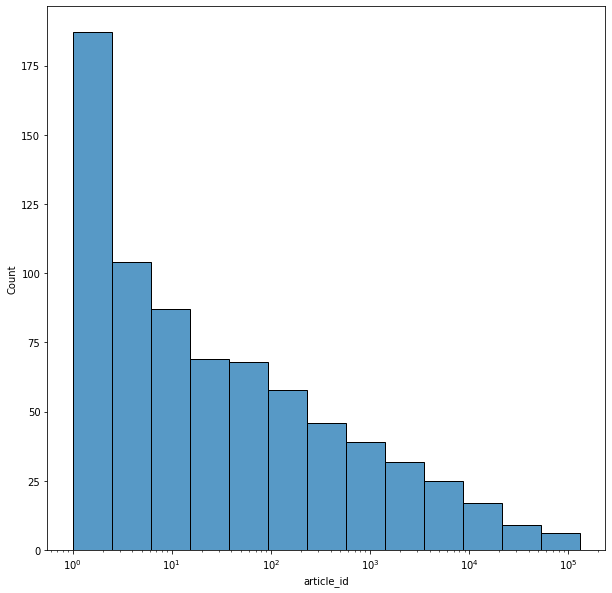

In [4]:
per_customer = transactions_df.groupby("customer_id")["article_id"].count()

print("Transactions per customer min = {}, mean = {:.3}, median = {:.3}, max = {}".format(per_customer.min(), per_customer.mean(), per_customer.median(), per_customer.max()))

plt.figure(figsize=(10,10))
sns.histplot(per_customer.value_counts(), log_scale=True)
per_customer.value_counts().head(10)

Transactions per articles min = 1, mean = 3.04e+02, median = 65.0, max = 50287


1     4491
2     3197
3     2634
4     2350
5     1997
6     1817
7     1645
8     1605
9     1492
10    1249
Name: customer_id, dtype: int64

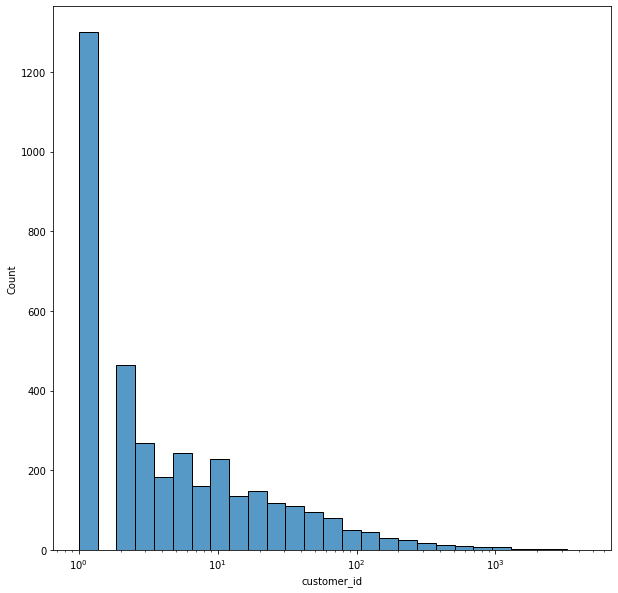

In [5]:
per_articles = transactions_df.groupby("article_id")["customer_id"].count()

print("Transactions per articles min = {}, mean = {:.3}, median = {:.3}, max = {}".format(per_articles.min(), per_articles.mean(), per_articles.median(), per_articles.max()))

plt.figure(figsize=(10,10))
sns.histplot(per_articles.value_counts(), log_scale=True)
per_articles.value_counts().head(10)

In [6]:
def draw_images(image_ids, rows=1):
    img_list = []
    for id in image_ids:
        image_path = "../input/h-and-m-personalized-fashion-recommendations/images/0{}/0{}.jpg".format(str(id)[:2], id)
        #image_path = make_image_path(id)
        #print(image_path)
        
        try:
            img = Image.open(image_path)
        except FileNotFoundError:
            img = Image.new(mode="RGBA", size=(50,50), color="red") 
            
            
        img_list.append(img)

    plt.figure(figsize=(20,3*rows))
    for j in range(len(image_ids)):
        plt.subplot(rows, len(image_ids)//rows, j+1)
        plt.axis('off')
        plt.imshow(img_list[j])
        plt.title(str(image_ids[j]), loc='center')

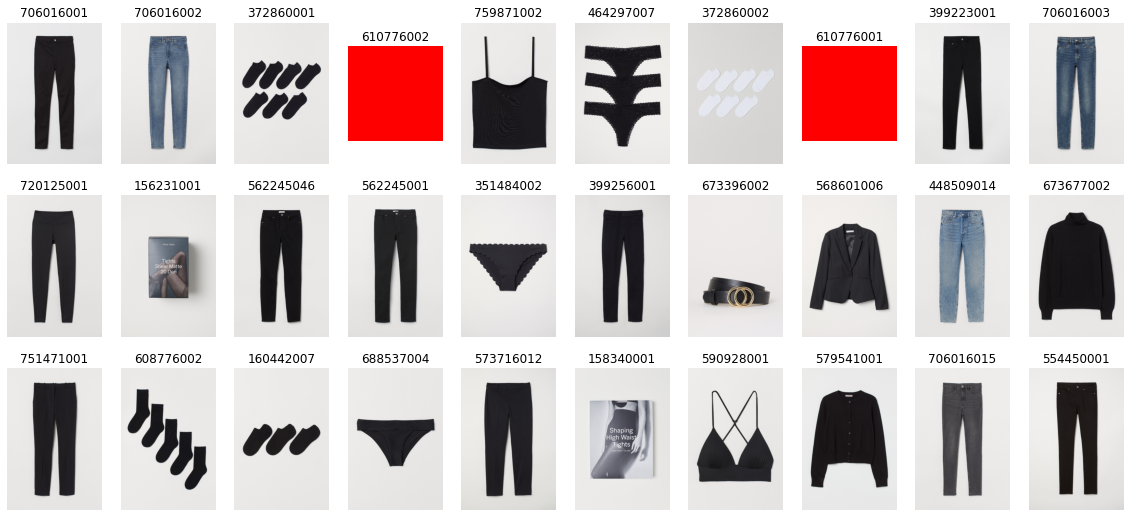

In [7]:
most_popular_30 = transactions_df.groupby("article_id")["customer_id"].count().sort_values(ascending=False).head(30).index.values
draw_images(most_popular_30, 3)

**Customers data**

In [8]:
customers_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv")
print(customers_df.shape)
customers_df.head()

(1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [9]:
customers_df.isna().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64

<AxesSubplot:>

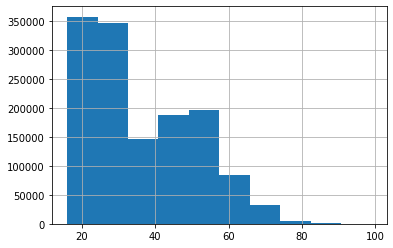

In [10]:
customers_df.age.hist()

In [11]:
customers_df.club_member_status.value_counts()

ACTIVE        1272491
PRE-CREATE      92960
LEFT CLUB         467
Name: club_member_status, dtype: int64

**Articles data**

In [12]:
articles_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv")
print(articles_df.shape)
articles_df.head().T  

(105542, 25)


,0,1,2,3,4
article_id,108775015,108775044,108775051,110065001,110065002
product_code,108775,108775,108775,110065,110065
prod_name,Strap top,Strap top,Strap top (1),OP T-shirt (Idro),OP T-shirt (Idro)
product_type_no,253,253,253,306,306
product_type_name,Vest top,Vest top,Vest top,Bra,Bra
product_group_name,Garment Upper body,Garment Upper body,Garment Upper body,Underwear,Underwear
graphical_appearance_no,1010016,1010016,1010017,1010016,1010016
graphical_appearance_name,Solid,Solid,Stripe,Solid,Solid
colour_group_code,9,10,11,9,10
colour_group_name,Black,White,Off White,Black,White


In [13]:
# Number of unique meanings of article features
for col in articles_df.columns:
    print(col, len(articles_df[col].unique()))
    

article_id 105542
product_code 47224
prod_name 45875
product_type_no 132
product_type_name 131
product_group_name 19
graphical_appearance_no 30
graphical_appearance_name 30
colour_group_code 50
colour_group_name 50
perceived_colour_value_id 8
perceived_colour_value_name 8
perceived_colour_master_id 20
perceived_colour_master_name 20
department_no 299
department_name 250
index_code 10
index_name 10
index_group_no 5
index_group_name 5
section_no 57
section_name 56
garment_group_no 21
garment_group_name 21
detail_desc 43405


In [14]:
articles_df.isna().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

Text(0.5, 1.0, 'Garment Group')

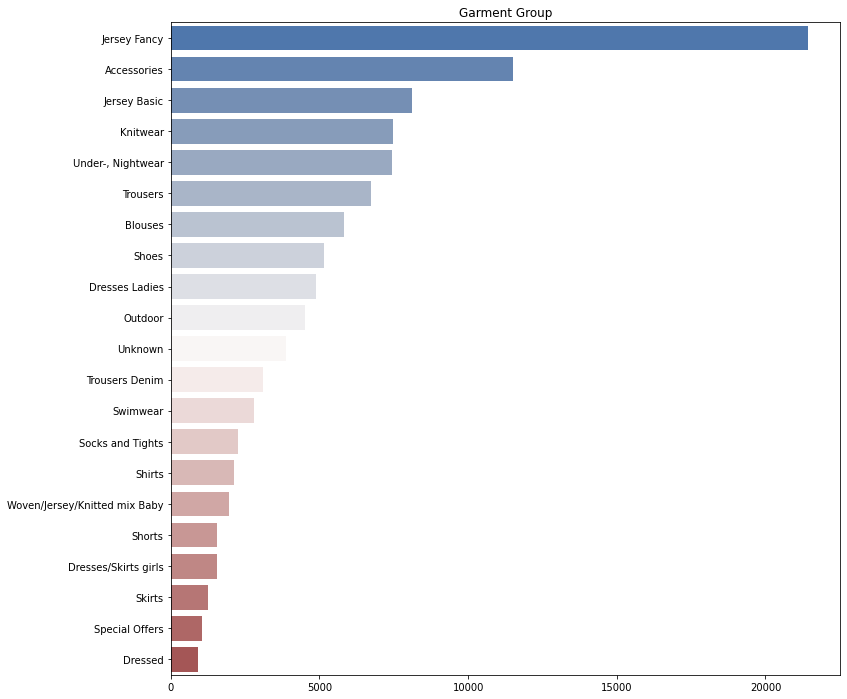

In [15]:
plt.figure(figsize=(12,12))
sns.barplot(y = articles_df.garment_group_name.value_counts().index, x=articles_df.garment_group_name.value_counts().values, palette="vlag")
plt.title("Garment Group", loc='center')

Text(0.5, 1.0, 'Index name')

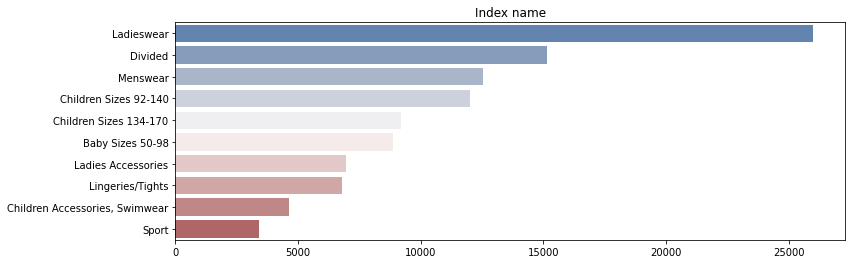

In [16]:
plt.figure(figsize=(12,4))
sns.barplot(y = articles_df.index_name.value_counts().index, x=articles_df.index_name.value_counts().values, palette="vlag")
plt.title("Index name", loc='center')

Text(0.5, 1.0, 'Index type')

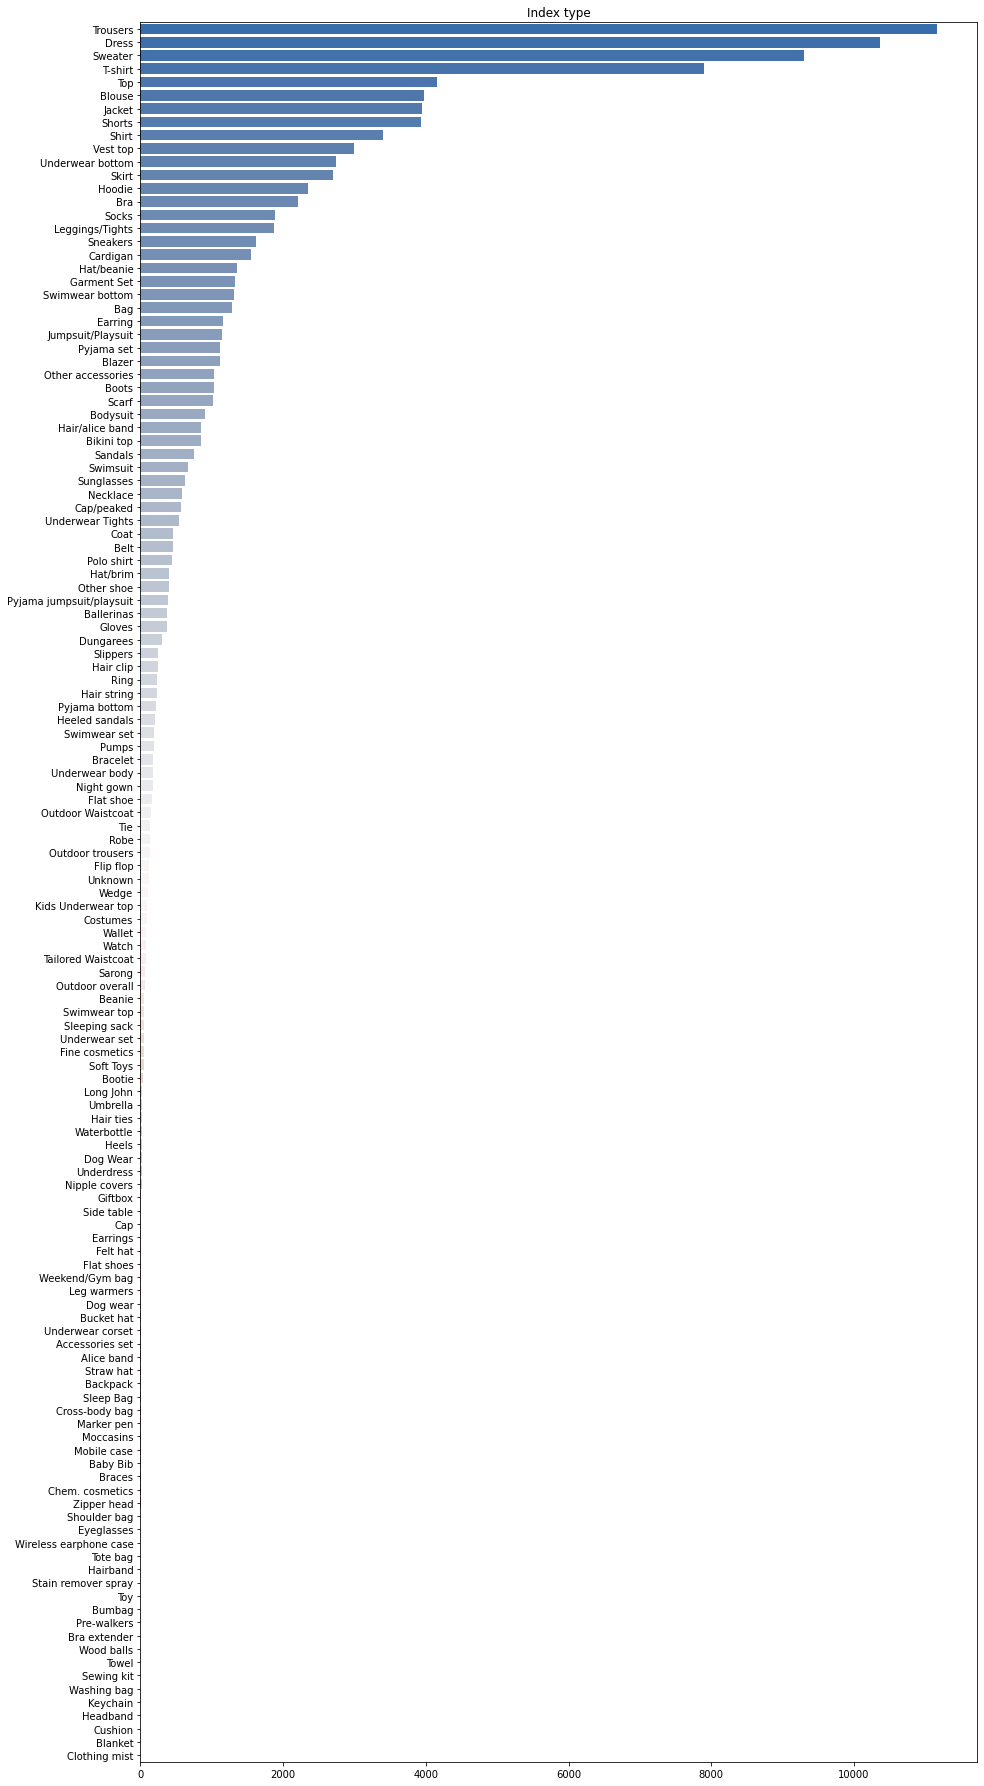

In [17]:
plt.figure(figsize=(15,32))
sns.barplot(y = articles_df.product_type_name.value_counts().index, x=articles_df.product_type_name.value_counts().values, palette="vlag")
plt.title("Index type", loc='center')

Text(0.5, 1.0, 'Product group')

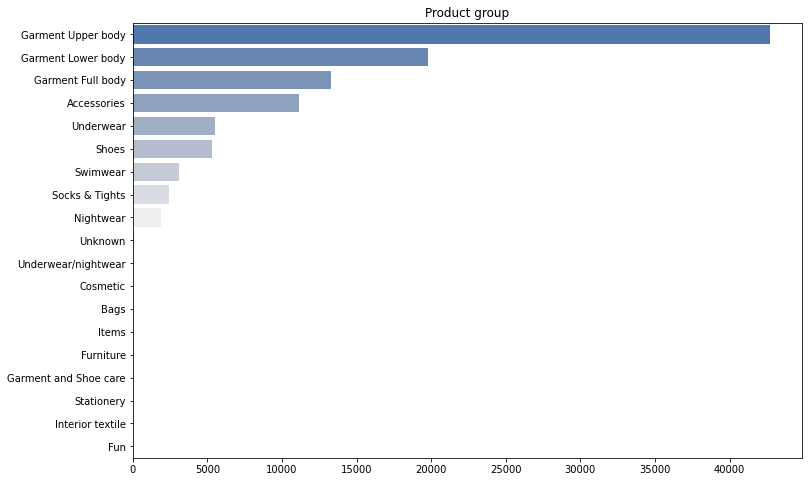

In [18]:
plt.figure(figsize=(12,8))
sns.barplot(y = articles_df.product_group_name.value_counts().index, x=articles_df.product_group_name.value_counts().values, palette="vlag")
plt.title("Product group", loc='center')

In [19]:
articles_detail_desc_len = articles_df.detail_desc.str.split().apply(lambda a: len(a) if type(a)==list else 1)
articles_detail_desc_len.describe()

count    105542.000000
mean         23.811923
std          11.688802
min           1.000000
25%          16.000000
50%          22.000000
75%          30.000000
max         121.000000
Name: detail_desc, dtype: float64